[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github.com/tulasiram58827/ocr_tflite/blob/main/colabs/ENDTOEND_OCR_TFLITE.ipynb)

This notebook is an end-to-end guide on how to do OCR with TFLite models.

We are using [CRAFT](https://arxiv.org/abs/1904.01941) as text Detector and [Keras OCR](https://github.com/faustomorales/keras-ocr) as text recognizer.

Regarding how to convert pretrained models you can visit these repositories.
- [CRAFT TFLITE CONVERSION](https://github.com/tulasiram58827/craft_tflite)
- [KERAS OCR TFLITE](https://github.com/tulasiram58827/ocr_tflite)

If you want more details on the conversion process of CRAFT and comparsion of CRAFT vs EAST you can refer these blogs.

- [Converting CRAFT to TFLite: A Guide to PyTorch-TFLite Conversion](https://tulasi.dev/craft-in-tflite)

- [A Battle of Text Detectors for Mobile Deployments: CRAFT vs. EAST](https://sayak.dev/optimizing-text-detectors/)


## SetUp

In [1]:
import tensorflow as tf

from skimage import io
from google.colab.patches import cv2_imshow
from imutils.object_detection import non_max_suppression

import numpy as np
import math
import time
import cv2
import string

## Download required files

In [ ]:
%%bash
# Download CRAFT and Keras OCR TFLite models and also demo image.

wget https://github.com/tulasiram58827/craft_tflite/raw/main/models/craft_float_800.tflite
wget https://github.com/tulasiram58827/ocr_tflite/raw/main/models/keras_ocr_float16.tflite
wget https://github.com/tulasiram58827/craft_tflite/raw/main/models/east/east_float_640.tflite
wget https://github.com/tulasiram58827/craft_tflite/raw/main/data/000.jpg
wget https://upload.wikimedia.org/wikipedia/commons/b/bd/Army_Reserves_Recruitment_Banner_MOD_45156284.jpg
mkdir output

## CRAFT UTILS

In [3]:
# Preprocess function for craft model
def craft_preprocess(image_path):
    image = io.imread(image_path)
    image = np.array(image).astype(np.float32)
    # Resizing image to tflite required size. If you are using higher dimension tflite model please change the 
    # dimensions here
    input_image = cv2.resize(image, dsize=(600, 800), interpolation=cv2.INTER_LINEAR)
    store_input_image = input_image.copy()
    # Normalizing Input with imagenet mean and variances
    mean=(0.485, 0.456, 0.406)
    variance=(0.229, 0.224, 0.225)
    input_image -= np.array([mean[0] * 255.0, mean[1] * 255.0, mean[2] * 255.0], dtype=np.float32)
    input_image /= np.array([variance[0] * 255.0, variance[1] * 255.0, variance[2] * 255.0], dtype=np.float32)
    image = np.transpose(input_image, (2, 0, 1))
    preprocessed_image = image[np.newaxis]
    return store_input_image, preprocessed_image

In [4]:
def craft_tflite_model(input_data):
    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=f"craft_float_800.tflite")
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
 
    # Test the model on random input data.
    input_shape = input_details[0]['shape']
    # input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    y = interpreter.get_tensor(output_details[0]['index'])
    feature = interpreter.get_tensor(output_details[1]['index'])

    return y, feature

In [5]:
def getDetBoxes_core(textmap, linkmap, text_threshold, link_threshold, low_text):
    # prepare data
    linkmap = linkmap.copy()
    textmap = textmap.copy()
    img_h, img_w = textmap.shape

    """ labeling method """
    ret, text_score = cv2.threshold(textmap, low_text, 1, 0)
    ret, link_score = cv2.threshold(linkmap, link_threshold, 1, 0)

    text_score_comb = np.clip(text_score + link_score, 0, 1)
    nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(text_score_comb.astype(np.uint8), connectivity=4)

    det = []
    mapper = []
    for k in range(1,nLabels):
        # size filtering
        size = stats[k, cv2.CC_STAT_AREA]
        if size < 10: continue

        # thresholding
        if np.max(textmap[labels==k]) < text_threshold: continue

        # make segmentation map
        segmap = np.zeros(textmap.shape, dtype=np.uint8)
        segmap[labels==k] = 255
        segmap[np.logical_and(link_score==1, text_score==0)] = 0   # remove link area
        x, y = stats[k, cv2.CC_STAT_LEFT], stats[k, cv2.CC_STAT_TOP]
        w, h = stats[k, cv2.CC_STAT_WIDTH], stats[k, cv2.CC_STAT_HEIGHT]
        niter = int(math.sqrt(size * min(w, h) / (w * h)) * 2)
        sx, ex, sy, ey = x - niter, x + w + niter + 1, y - niter, y + h + niter + 1
        # boundary check
        if sx < 0 : sx = 0
        if sy < 0 : sy = 0
        if ex >= img_w: ex = img_w
        if ey >= img_h: ey = img_h
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1 + niter, 1 + niter))
        segmap[sy:ey, sx:ex] = cv2.dilate(segmap[sy:ey, sx:ex], kernel)

        # make box
        np_contours = np.roll(np.array(np.where(segmap!=0)),1,axis=0).transpose().reshape(-1,2)
        rectangle = cv2.minAreaRect(np_contours)
        box = cv2.boxPoints(rectangle)

        # align diamond-shape
        w, h = np.linalg.norm(box[0] - box[1]), np.linalg.norm(box[1] - box[2])
        box_ratio = max(w, h) / (min(w, h) + 1e-5)
        if abs(1 - box_ratio) <= 0.1:
            l, r = min(np_contours[:,0]), max(np_contours[:,0])
            t, b = min(np_contours[:,1]), max(np_contours[:,1])
            box = np.array([[l, t], [r, t], [r, b], [l, b]], dtype=np.float32)

        # make clock-wise order
        startidx = box.sum(axis=1).argmin()
        box = np.roll(box, 4-startidx, 0)
        box = np.array(box)

        det.append(box)
        mapper.append(k)

    return det, labels, mapper

def adjustResultCoordinates(polys, ratio_w, ratio_h, ratio_net = 2):
    if len(polys) > 0:
        polys = np.array(polys)
        for k in range(len(polys)):
            if polys[k] is not None:
                polys[k] *= (ratio_w * ratio_net, ratio_h * ratio_net)
    return polys
  
# Postprocessing output from craft TFLite Model
def postprocess_craft(y, feature, image):
    score_text = y[0,:,:,0]
    score_link = y[0,:,:,1]
    text_threshold = 0.7
    link_threshold = 0.4
    low_text = 0.4
    ratio_w = ratio_h = 1
    boxes, labels, mapper = getDetBoxes_core(score_text, score_link, text_threshold, link_threshold, low_text)
    polys = [None] * len(boxes)
    boxes = adjustResultCoordinates(boxes, ratio_w, ratio_h)
    for k in range(len(polys)):
        if polys[k] is None: polys[k] = boxes[k]
    output_image = image[:,:,::-1].copy()
    crops = list()
    for i, box in enumerate(polys):
        poly = np.array(box).astype(np.int32).reshape((-1))
        poly = poly.reshape(-1, 2)
        min_co = tuple(np.min(poly, axis=0))
        max_co = tuple(np.max(poly, axis=0))
        cv2.rectangle(output_image, min_co, max_co, (0, 0, 255), 2)
        crops.append([min_co, max_co])
    return output_image, crops

## EAST UTILS

In [6]:
def preprocess_east(image_path):
    input_image = cv2.imread(image_path)
    orig = input_image.copy()
    (H, W) = input_image.shape[:2]
    (newW, newH) = (416, 640)
    rW = W / float(newW)
    rH = H / float(newH)
    image = cv2.resize(input_image, (newW, newH))
    (H, W) = image.shape[:2]
    image = image.astype("float32")
    mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
    image -= mean
    image = np.expand_dims(image, 0)
    return input_image, image, rW, rH

In [7]:
def run_east_tflite(input_data):
    interpreter = tf.lite.Interpreter(model_path='/content/east_float_640.tflite')
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    scores = interpreter.tensor(interpreter.get_output_details()[0]['index'])()
    geometry = interpreter.tensor(interpreter.get_output_details()[1]['index'])()
    return scores, geometry

In [8]:
def postprocess_east(scores, geometry, rW, rH, orig):
    scores = np.transpose(scores, (0, 3, 1, 2)) 
    geometry = np.transpose(geometry, (0, 3, 1, 2))
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        for x in range(0, numCols):
          if scoresData[x] < 0.5:
            continue
          (offsetX, offsetY) = (x * 4.0, y * 4.0)
          angle = anglesData[x]
          cos = np.cos(angle)
          sin = np.sin(angle)
          h = xData0[x] + xData2[x]
          w = xData1[x] + xData3[x]
          endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
          endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
          startX = int(endX - w)
          startY = int(endY - h)
          rects.append((startX, startY, endX, endY))
          confidences.append(scoresData[x])
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    crops = []
    for (startX, startY, endX, endY) in boxes:
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
        crops.append([[startX, startY], [endX, endY]])
    return orig, crops

## KERAS OCR UTILS

In [9]:
def preprocess_ocr(image):
    input_data = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    input_data = cv2.resize(input_data, (200, 31))
    input_data = input_data[np.newaxis]
    input_data = np.expand_dims(input_data, 3)
    input_data = input_data.astype('float32')/255
    return input_data

In [10]:
def run_tflite_ocr(input_data):
    interpreter = tf.lite.Interpreter(model_path='/content/keras_ocr_float16.tflite')
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_shape = input_details[0]['shape']
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])
    return output

In [11]:
# Code for CTC Decoder 
alphabets = string.digits + string.ascii_lowercase
blank_index = len(alphabets)

def decoder(y_pred, greedy=True):
    input_shape = tf.keras.backend.shape(y_pred)
    input_length = tf.ones(shape=input_shape[0]) * tf.keras.backend.cast(
        input_shape[1], 'float32')
    # You can turn on beam search decoding using greedy=False and also play with beam_width parameter.
    unpadded = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=greedy, beam_width=5)[0][0]
    unpadded_shape = tf.keras.backend.shape(unpadded)
    padded = tf.pad(unpadded,
                    paddings=[[0, 0], [0, input_shape[1] - unpadded_shape[1]]],
                    constant_values=-1)
    return padded
  
def postprocess_ocr(output, greedy=True):
  # Running decoder on TFLite Output
    decoded = decoder(output, greedy)
    final_output = "".join(alphabets[index] for index in decoded[0] if index not in [blank_index, -1])
    return final_output

## END TO END OCR INFERENCE

In [27]:
image_path = '/content/Army_Reserves_Recruitment_Banner_MOD_45156284.jpg'

In [28]:
def run_ocr(image_path, detector='east', greedy=True):
    start_time = time.time()
    if detector == 'east':
        input_image, preprocessed_image, rW, rH = preprocess_east(image_path)
        scores, geometry = run_east_tflite(preprocessed_image)
        output, crops = postprocess_east(scores, geometry, rW, rH, input_image)
    elif detector == 'craft':
        input_image, preprocessed_image = craft_preprocess(image_path)
        y, feature = craft_tflite_model(preprocessed_image)
        output, crops = postprocess_craft(y, feature, input_image)
    else:
        print("Please provide valid detector")
    # i = 0
    for box in crops:
        cropped_image = input_image[box[0][1]:box[1][1], box[0][0]:box[1][0], :]
        # Uncomment it if you want to see the croppd images in output folder
        # cv2.imwrite(f'output/{i}.jpg', cropped_image)
        processed_image = preprocess_ocr(cropped_image)
        ocr_output = run_tflite_ocr(processed_image)
        final_output = postprocess_ocr(ocr_output, greedy)
        cv2.putText(output, final_output, (box[0][0], box[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    print(f"Time taken to run OCR Model with {detector} detector and KERAS OCR is", time.time()-start_time)
    return output     

In [29]:
final_image = run_ocr(image_path, detector='east', greedy=True)

Time taken to run OCR Model with east detector and KERAS OCR is 6.868072271347046


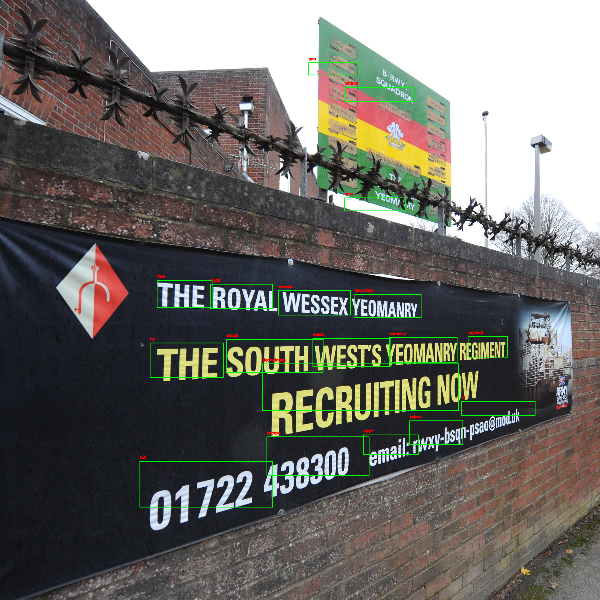

In [31]:
# Resizing is just to reduce the memory of notebook. You can comment it out
final_image = cv2.resize(final_image, (600,600))
cv2_imshow(final_image)

In [32]:
final_image = run_ocr(image_path, detector='craft', greedy=True)

Time taken to run OCR Model with craft detector and KERAS OCR is 12.906928300857544


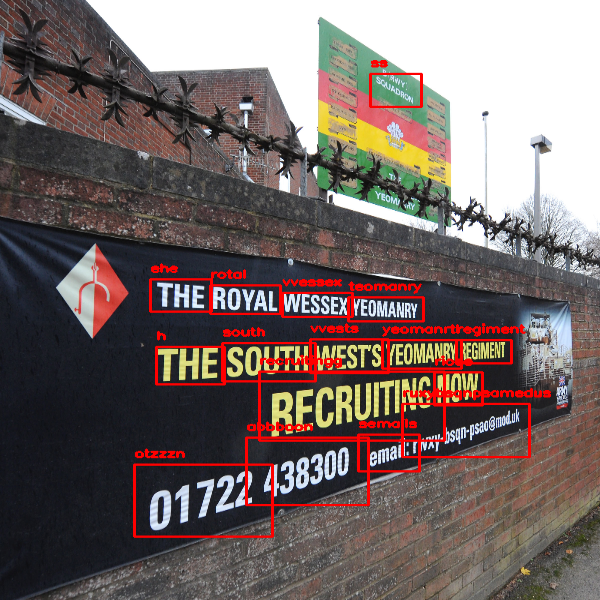

In [34]:
# Resizing is just to reduce the memory of notebook. You can comment it out
final_image = cv2.resize(final_image, (600,600))
cv2_imshow(final_image)

*Note: The results are bad may be because the data the model trained is different from the inference data*

## Acknowlegments

- EAST Models are created from this [Notebook](https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/EAST_TFLite.ipynb)
- EAST pre-processing, inference code and post-processing code are also taken from the same [Notebook](https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/blob/master/EAST_TFLite.ipynb)
- CRAFT Models are used from this [Repository](https://github.com/tulasiram58827/craft_tflite)
- CRAFT pre-processing and post-processing are taken from this [Repository](https://github.com/clovaai/CRAFT-pytorch)
- KERAS OCR Models are available in this repository itself.
- KERAS OCR processing code are taken from this [Repository](https://github.com/faustomorales/keras-ocr)